<a href="https://colab.research.google.com/github/probabll/mixed-rv-vae/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%load_ext autoreload
#%autoreload 2

On Colab, you will need to clone and install [probabll/dists.pt](https://github.com/probabll/dists.pt.git)

In [ ]:
#!git clone https://github.com/probabll/dists.pt.git

In [ ]:
#cd dists.pt

In [ ]:
#!git pull

In [ ]:
#pip install .

In [ ]:
#cd ..

# Mixed RVs via Mixture of Dirichlets

In this notebook I develop a VAE whose latent code is a mixed rv on $\Delta_{K-1}$, that is, a sparse probability vector, via the so called *stratified representation*, that is, as a finite mixture of distributions on the faces of $K-1$-dimensional simplex.





## Stratified Representation


Let $Y$ be an rv taking on values in the simplex $\Delta_{K-1}$. The density assigned to an outcome $y \in \Delta_{K-1}$ is given by

\begin{align}
  p_{Y}(y|\alpha, \omega) &= \sum_{f} p_F(f|\omega) p_{Y|F}(y|f, \alpha) \\
  &= \sum_f \mathrm{Gibbs}(f|\omega) \mathrm{Dir}(y|\alpha_f)
\end{align}

where $f$ is a face of dimensionality $0 < \mathrm{dim}(f) < K -1$ and we choose a $(\mathrm{dim}(f)+1)$-dimensional Dirichlet distribution for $Y|F=f$. The simplex $\Delta_{K-1}$ has $2^K-1$ non-empty faces, each of which we represent by a $K$-dimensional vector $f \in \{0,1\}^K$ where $f_k$ indicates whether the vertex $\mathbf e_k$ is in the face. 

$F$ takes on values in the sample space $\mathcal F = \{0,1\}^K \setminus \{\mathbf 0_K\}$, and 

\begin{align}
p_{F}(f|\omega) &\propto \prod_{k=1}^K f_k \exp(\omega) + (1-f_k) \exp(-\omega)
\end{align}

The sample space $\mathcal F$ can be efficiently represented in a finite-state automaton of size $\mathcal O(K)$. As the unnormalised probability of any assignment $f$ factorises along the transitions of this automaton, the normalisation constant can be computed efficiently using the *value recursion* (or backward algorithm). Samples can be obtained with a linear pass through this automaton. Combining the value recursion and the *reverse value recursion* (forward algorithm), we can also compute the marginal probability $\Pr(F_k = 1)$ for any $k \in [K]$, as well as $\mathbb E[\psi(F)]$ for any function $\psi$ that factorises along $f_k$. One such function is surprisal $\log p_F(f|\omega)$, thus entropy, cross-entropy and KL divergence are available in closed-form. 

The parameters $\alpha_f \in \mathbb R_{>0}^{\mathrm{dim}(f)+1}$ can be shared across faces (or predicted via a shared parameterisation).

**Gradient estimation**

We assume samples from $Y|F=f, \alpha$ can be reparameterised in terms of samples from a fixed distribution $\Gamma$ independent of $\alpha$, i.e. $\gamma = \mathcal T^{-1}(y; \alpha_f) \sim \Gamma$, 
and use score function estimation for gradient estimation with respect to $\omega$:

\begin{align}
    \nabla_{\alpha,\omega} \mathbb E_{Y|\alpha, \omega}\left[ \psi(y) \right] &= \nabla_{\omega} \mathbb E_{F|\omega}\left[ \nabla_{\alpha} \mathbb E_{Y|F,\alpha} \left[ \psi(y) \right] \right] \\
    &= \mathbb E_{F|\omega}\left[ \left( \nabla_{\alpha} \mathbb E_{Y|F,\alpha} \left[ \psi(y) \right] \right)\nabla_{\omega} \log p_F(f) \right] \\
    &= \mathbb E_{F|\omega}\left[  \mathbb E_{} \left[ \nabla_{y} \psi(y) \nabla_{\alpha_f} \mathcal T(\gamma; \alpha_f) \right] \nabla_{\omega} \log p_F(f) \right]
\end{align}

For variance reduction we can use baselines based on summary statistics (e.g., mean, standard deviation), on trained MLPs, or based on $\nabla_{\alpha} \mathbb E_{Y|F,\alpha}[ \psi(y')]$ assessed at an additional sample $y'$ (this is known as  a self-critic). More sophisticated techniques are possible (but hopefully won't be needed).

In [1]:
import torch
torch.__version__

'1.8.1+cu102'

In [2]:
import numpy as np
import torch
import torch.distributions as td
import probabll.distributions as pd

# VAE

A variational auto-encoder approximates the distribution of $X$ on sample space $\mathcal X$ as a marginal of a joint distribution $X,Z|\theta$ whose pdf factorises $p_{XZ}(x, z|\theta) = p_{Z}(z|\theta)p_{X|Z}(x|z, \theta)$. Inference employs an independently parameterised  approximation $Z|X=x, \lambda$ to the true posterior distribution $Z|X=x, \theta$. The parameters $\theta$ of the generative model and $\lambda$ of the inference model are estimated jointly to maximise a lowerbound on the log-evidence (the ELBO):

\begin{align}
\theta^\star, \theta^\star &= \arg\,\max_{\theta, \lambda} ~ \sum_{x \sim \mathcal D}\mathrm{ELBO}_x(\theta, \lambda) \\
&= \arg\,\max_{\theta, \lambda} ~ \sum_{x \sim \mathcal D} \mathbb E_{Z|X,\lambda}\left[ \log \frac{p_{XZ}(x, z|\theta)}{q_{Z|X}(z|x, \lambda)} \right]
\end{align}

For us, $Z$ can be a $K$-dimensional mixed rv, a combination of an $H$-dimensional Gaussian embedding and a $K$-dimensional mixed rv, etc. In this notebook, an observed data point $x$ is an MNIST digit, i.e., $x\in \{0, 1\}^{D}$.

In [3]:
import torch.nn as nn


def assert_shape(t, shape, message):
    assert t.shape == shape, f"{message} has the wrong shape: got {t.shape}, expected {shape}"        


## Generative model

\begin{align}
p_{XYF}(f, y, z, x|\theta) &= p_{F}(f)p_{Y|F}(y|f, \theta)p_Z(z)p_{X|Y}(x|y, \theta) \\
&= \mathrm{Gibbs}(f|\mathbf 0_K) \times \mathrm{Dir}(y|\mathbf 1_{\mathrm{dim}(f)+1}) \times \mathcal N(z|0, I_H) \times \prod_{d=1}^D \mathrm{Bern}(x_d|b_d(y; \theta))
\end{align}

where the Gibbs distribution is constrained to supporting all but the empty face of $\Delta_{K-1}$, and $\mathbf b(x, y;\theta) \in (0,1)^D$ is the output of an NN with parameters $\theta$.

It's possible to replace a Gaussian prior by other differentiably reparameterisable distribution.

In [4]:
from components import GenerativeModel

## Inference model

\begin{align}
q_{ZFY|X}(f, y, z|x,\lambda) &=q_{F|X}(f|x, \lambda) q_{Y|FX}(y|f,x, \lambda)  q_{Z|XY}(z|x,y, \lambda)\\
&= \mathrm{Gibbs}(f|\mathbf s(x; \lambda)) \times \mathrm{Dir}(y|\mathbf a(x, f;\lambda)) \times \mathcal N(z|\mathbf u(x, y; \lambda), \mathbf v(x, y; \lambda)) 
\end{align}

where $\mathbf s(x; \lambda) \in \mathbb R^K$, $\mathbf a(x, f; \lambda) \in \mathbb R_{>0}^{\mathrm{dim}(f)+1}$, $\mathbf u(x; \lambda) \in \mathbb R^H$, and $\mathbf v(x; \lambda) \in \mathbb R_{>0}^K$, are NN outputs; $\lambda$ denotes the NN parameters.

In case the generative model uses a non-Gaussian prior for $Z$, the variational factor for $Z$ must be changed accordingly. 

Optionally, we may introduce a mean field assumption and make $Z \perp Y \mid X=x, \lambda$.

In [5]:
from components import InferenceModel

## ELBO

For a single observation $x$, our ELBO corresponds to:

\begin{align}
\mathrm{ELBO}_x(\theta, \lambda) 
&=  \mathbb E_{F|X=x,\lambda} \left[ \mathbb E_{Y,Z|X=x,F=f,\lambda} \left[ \log p_{X|YZ}(x|y,z,\theta)  \right] \right] \\
&- \mathbb E_{F|X=x,\lambda} \left[  \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \right]\\
&- \mathbb E_{F|X=x,\lambda} \left[ \mathbb E_{Y|X=x,F=f,\lambda} \left[ \mathrm{KL}(Z|X=x,Y=y, \lambda \mid\mid Z|\theta ) \right] \right] \\
&- \mathrm{KL}(F|X=x,\lambda \mid\mid F|\theta )
\end{align}

A gradient estimator for $\theta$ can be obtained via
\begin{align}
\nabla_\theta \mathrm{ELBO}_x(\theta, \lambda)&\approx \nabla_\theta \log p_{X|YZ}(x|y, z,\theta) \\
&- \nabla_\theta \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \\
&- \nabla_\theta \mathrm{KL}(F|X=x,\lambda \mid\mid F|\theta ) \\
&- \nabla_\theta \mathrm{KL}(Z|X=x,Y=y, \lambda \mid\mid Z|\theta )
\end{align}
with $x \sim \mathcal D$ and $f, y, z \sim F,Y,Z|X=x, \lambda$.

A gradient estimator for $\lambda$ can be obtained via $\nabla_\lambda  \mathrm{ELBO}_x(\theta, \lambda) \approx$
\begin{align}
& \nabla_{\lambda} \log p_{X|YZ}(x|y=\mathcal T(\gamma; \lambda), z=\mathcal S(\epsilon; \lambda), \theta) \\
&-\nabla_\lambda \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \\
&-\nabla_\lambda \mathrm{KL}(F|X=x,\lambda \mid\mid F|\theta ) \\
&-\nabla_\lambda \mathrm{KL}(Z|X=x,Y=T(\gamma; \lambda), \lambda \mid\mid Z|\theta ) \\
&+\left( \log p_{X|YZ}(x|y,z, \theta) -  \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \right.\\
&\left. -  \mathrm{KL}(Z|X=x,Y=y,\lambda || Z|\theta) \right) \nabla_\lambda \log q_{F|X}(f|x,\lambda)
\end{align}
with $z = \mathcal S(\epsilon; \lambda)$ for $\epsilon \sim \Phi$, $f \sim F|X=x,\lambda$, $y = \mathcal T(\gamma; \lambda)$ for $\epsilon \sim \Gamma$.

A surrogate loss $\ell$ in `pytorch` is given by 
\begin{align}
D&=-\log p_{X|YZ}(x|y,z, \theta) \\
R_Y&= \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \\
R_F&= \mathrm{KL}(F|X=x,\lambda \mid\mid F|\theta )\\
R_Z&= \mathrm{KL}(Z|X=x,Y=y,\lambda \mid\mid Z|\theta )\\
r&=  -D - R_Y -R_Z \\
g_{\text{rep}} &= -D - R_F -R_Y -R_Z \\
g_{\text{sfe}} &= \mathrm{detach}(r) \log q_{F|X}(f|x,\lambda)\\
\ell &= -(g_{\text{rep}} + g_{\text{sfe}})
\end{align}
again with $z = \mathcal S(\epsilon; \lambda)$ for $\epsilon \sim \Phi$, $f \sim F|X=x,\lambda$, $y = \mathcal T(\gamma; \lambda)$ for $\epsilon \sim \Gamma$.

In [6]:
from components import VAE

# MNIST 


## Hyperparameters

In [7]:
from collections import namedtuple

In [8]:
cfg = dict(
    # Data
    batch_size=200,
    data_dir='tmp',
    height=28,
    width=28, 
    # CUDA
    device='cuda:0',
    # Joint distribution    
    y_dim=10,    
    prior_scores=0.0,
    z_dim=32,     
    z_dist='gaussian',    
    prior_location=0.0, 
    prior_scale=1.0,
    hidden_dec_size=500,
    # Approximate posteriors
    shared_concentrations=True,
    mean_field=False,
    hidden_enc_size=500,    
    # Training
    epochs=200,    
    # Evaluation
    num_samples=100,    
    # Optimisation & regularisation
    gen_lr=1e-4,
    inf_lr=1e-4,  
    gen_l2=1e-4,
    inf_l2=1e-4,  
    gen_p_drop=0.1,  
    inf_p_drop=0.0,  # dropout for inference model is not well understood    
    grad_clip=5.0,
    # Variance reduction
    use_self_critic=False,
    use_reward_standardisation=True,
)
args = namedtuple('Config', cfg.keys())(*cfg.values())

## Batcher

In [9]:
# You can skip this on Colab

# Download MNIST
#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz

In [10]:
from data import load_mnist
train_loader, valid_loader, test_loader = load_mnist(
    args.batch_size, 
    save_to='./', 
    height=args.height, 
    width=args.width
)

In [11]:
from data import Batcher
def get_batcher(data_loader, args):
    batcher = Batcher(
        data_loader, 
        height=args.height, 
        width=args.width, 
        device=torch.device(args.device), 
        binarize=True, 
        num_classes=10,
        onehot=True
    )
    return batcher

## Model

In [12]:
p = GenerativeModel(    
    y_dim=args.y_dim,
    z_dim=args.z_dim, 
    data_dim=args.height * args.width, 
    hidden_dec_size=args.hidden_dec_size,
    p_drop=args.gen_p_drop,
    prior_scores=args.prior_scores,
    prior_location=args.prior_location,
    prior_scale=args.prior_scale,
    z_dist=args.z_dist,
).to(torch.device(args.device))

In [13]:
q = InferenceModel(    
    y_dim=args.y_dim,
    z_dim=args.z_dim, 
    data_dim=args.height * args.width, 
    hidden_enc_size=args.hidden_enc_size,
    shared_concentrations=args.shared_concentrations,
    p_drop=args.inf_p_drop,
    z_dist=args.z_dist,
    mean_field=args.mean_field,
).to(torch.device(args.device))

In [20]:
q.sample(p.sample((2,))[-1])

(tensor([[0., 0., 1., 0., 1., 1., 1., 0., 1., 1.],
         [0., 1., 1., 1., 1., 0., 0., 1., 1., 0.]], device='cuda:0'),
 tensor([[0.0000, 0.0000, 0.0034, 0.0000, 0.0283, 0.4175, 0.1135, 0.0000, 0.1300,
          0.3073],
         [0.0000, 0.1294, 0.0034, 0.1129, 0.0788, 0.0000, 0.0000, 0.5308, 0.1448,
          0.0000]], device='cuda:0'),
 tensor([[ 1.6658e+00, -1.7977e+00, -4.2875e-01, -1.3942e-01,  1.0474e-01,
           2.0443e-01, -7.4791e-01, -2.7756e-01,  1.0920e+00,  4.8533e-03,
           2.6913e-01,  1.0767e+00,  1.0606e-01,  6.7673e-01,  6.5095e-01,
           6.3389e-01,  2.0148e-01, -2.4966e-01,  2.0562e-01, -7.8201e-01,
           4.0111e-01, -7.7837e-02,  3.6271e-01, -2.1231e-01,  4.1992e-01,
           1.2408e+00, -1.3265e-01,  9.5850e-02, -7.7718e-01, -9.4726e-04,
          -7.4964e-01,  6.3575e-01],
         [ 2.8416e-01, -3.4288e-01,  1.5786e+00,  2.7257e-01,  4.4486e-01,
          -2.7319e-01,  6.4163e-01, -3.9482e-01, -2.1932e-01,  5.2783e-02,
          -1.9282e-01

In [22]:
q.log_prob(
    torch.zeros(args.height * args.width, device=torch.device(args.device)),
    *q.sample(p.sample((2,))[-1]), 
)

tensor([-34.5728, -37.2425], device='cuda:0', grad_fn=<AddBackward0>)

In [23]:
vae = VAE(
    p, 
    q, 
    use_self_critic=args.use_self_critic, 
    use_reward_standardisation=args.use_reward_standardisation
)

## Visualisations

* Compare statistics of samples from $p$ to those of samples from $q$
* Visualise a few generations

In [24]:
from matplotlib import pyplot as plt
from collections import defaultdict

In [25]:
def bitvec2str(f, as_set=False):
    return ''.join('1' if b else '0' for b in f) if not as_set else '{' + ','.join(f'{i:1d}' for i, b in enumerate(f, 1) if b) + '}'

In [26]:
def compare_p_q(vae, batcher: Batcher, args): 
    with torch.no_grad():
        vae.eval()        
    
        prior = defaultdict(list)
        posterior = defaultdict(list)
        other = defaultdict(list)
        num_obs = 0

        # Some visualisations
        for x_obs, y_obs in batcher:
            
            # [B, H*W]
            x_obs = x_obs.reshape(-1, args.height * args.width)
            num_obs += x_obs.shape[0]

            # [B, 10]
            context = None
            
            B, H, K, D = x_obs.shape[0], vae.p.z_dim, vae.p.y_dim, vae.p.data_dim            
                        
            # [B, K]
            f = vae.p.F().expand((B,)).sample()
            y = vae.p.Y(f).sample()
            # [B, H]
            z = vae.p.Z().expand((B,)).sample()
            #x = vae.p.X(z=z, y=y).sample()
                        
            # [B, K]
            prior['f'].append(f.cpu().numpy())
            # [B]
            prior['dim'].append(f.sum(-1).cpu().numpy())
            # [B, K]
            prior['y'].append(y.cpu().numpy())
            # [B, K]
            prior['z'].append(z.cpu().numpy())
            
            # [B, K], [B, K], [B, H]
            f, y, z = vae.q.sample(x_obs)            
            # [B, K]
            posterior['f'].append(f.cpu().numpy())
            # [B]
            posterior['dim'].append(f.sum(-1).cpu().numpy())
            # [B, K]
            posterior['y'].append(y.cpu().numpy())
            # [B, H]
            posterior['z'].append(z.cpu().numpy())
            
            # [B]            
            other['KL_F'].append(td.kl_divergence(q.F(x_obs), p.F().expand((B,))).cpu().numpy())
            other['KL_Y'].append(td.kl_divergence(q.Y(x=x_obs, f=f), p.Y(f)).cpu().numpy())
            other['KL_Z'].append(td.kl_divergence(q.Z(x=x_obs, y=y), p.Z().expand((B,))).cpu().numpy())
            
        # KLs
        print("For a trained VAE: ")
        print(" 1. We want to see that KL(Z|x || Z), KL(F|x || F), and KL(Y|f,x || Y|f) are generally > 0 for any x ~ D.")
        
        if vae.p.z_dim:
            _ = plt.hist(np.concatenate(other['KL_Z'], 0), bins=20)
            _ = plt.xlabel(r'$KL( Z|x,\lambda || Z| \theta )$')
            plt.show()

        if vae.p.y_dim:
            _ = plt.hist(np.concatenate(other['KL_F'], 0), bins=20)
            _ = plt.xlabel(r'$KL( F|x,\lambda || F| \theta )$')
            plt.show()

            _ = plt.hist(np.concatenate(other['KL_Y'], 0), bins=20)
            _ = plt.xlabel(r'$KL( Y|f,x,\lambda || Y|f, \theta )$')
            plt.show()
            
        
        print(" 2. But, marginally, we expect E_X[Z|X] ~ Z E_X[F|X] ~ F and E_FX[Y|F,X] ~ E_F[Y|F].")
        
        if vae.p.z_dim:
            _ = plt.hist(np.concatenate(prior['z'], 0).flatten(), density=True, alpha=0.3, label='Z')
            _ = plt.hist(np.concatenate(posterior['z'], 0).flatten(), density=True, alpha=0.3, label='E[Z|X,Y]')
            _ = plt.xlabel(r'$Z_d$')
            _ = plt.legend()
            plt.show()

        if vae.p.y_dim:
            # Pr(F_k = 1) compared to E_X[ I[F_k = 1] ]
            _ = plt.imshow(
                np.stack([vae.p.F().marginals().cpu().numpy(), np.concatenate(prior['f'], 0).mean(0), np.concatenate(posterior['f'], 0).mean(0)]), 
                interpolation='nearest',
            )
            _ = plt.colorbar()
            _ = plt.xlabel('k')
            _ = plt.yticks([0,1, 2], ['F', 'E[F]', 'E[F|X]'])
            _ = plt.title(r'Marginal probability that $F_k = 1$')
            plt.show()

            # Y_k compared to E_X[Y_k]

            _ = plt.imshow(
                np.stack([np.concatenate(prior['y'], 0).mean(0), np.concatenate(posterior['y'], 0).mean(0)]), 
                interpolation='nearest'
            )
            _ = plt.colorbar()
            _ = plt.xlabel('k')
            _ = plt.yticks([0, 1], ['E[Y|F]', 'E[Y|F,X]'])
            _ = plt.title(r'Average $Y_k$')
            plt.show()

            _ = plt.hist(
                np.concatenate(prior['dim'], 0), 
                alpha=0.3, label='dim(F)', bins=np.arange(0, 11))
            _ = plt.hist(
                np.concatenate(posterior['dim'], 0), 
                alpha=0.3, label='E[dim(F)|X]', bins=np.arange(0, 11))
            _ = plt.ylabel(f'Count')
            _ = plt.xlabel('dim(f)+1')
            _ = plt.xticks(np.arange(1,11), np.arange(1,11))
            _ = plt.title(f'Distribution of dim(f)')
            _ = plt.legend()
            plt.show()


For a trained VAE: 
 1. We want to see that KL(Z|x || Z), KL(F|x || F), and KL(Y|f,x || Y|f) are generally > 0 for any x ~ D.


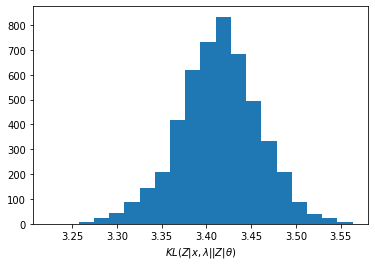

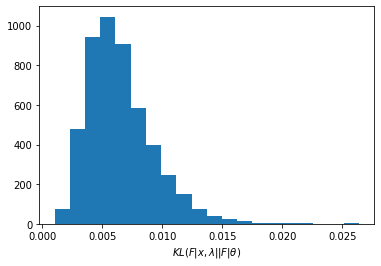

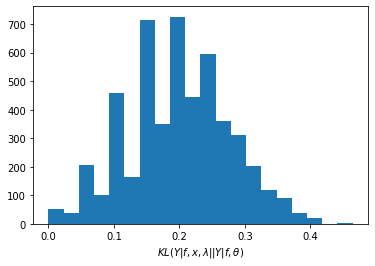

 2. But, marginally, we expect E_X[Z|X] ~ Z E_X[F|X] ~ F and E_FX[Y|F,X] ~ E_F[Y|F].


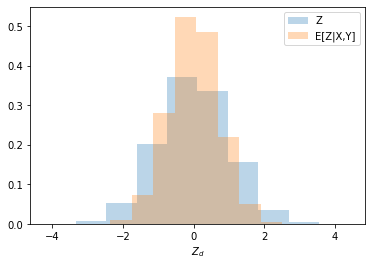

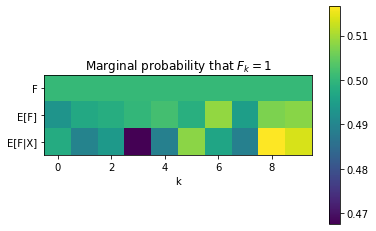

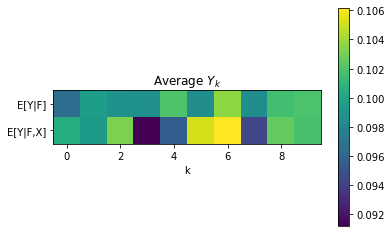

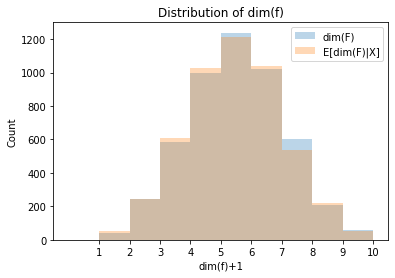

In [27]:
compare_p_q(vae, get_batcher(valid_loader, args), args)

In [28]:
def visualize(vae, batcher: Batcher, args, N=4, num_figs=1): 

    assert N <= args.batch_size, "N should be no bigger than a batch"
    with torch.no_grad():
        vae.p.eval()        
        vae.q.eval()
            
        # Some visualisations
        for r, (x_obs, y_obs) in enumerate(batcher, 1):

            plt.figure(figsize=(2*N, 2*N))
            plt.subplots_adjust(wspace=0.5, hspace=0.5)        
        
            
            # [B, H*W]
            x_obs = x_obs.reshape(-1, args.height * args.width)
            x_obs = x_obs[:N]
            # [B, 10]
            context = None
            
            B, H, K, D = x_obs.shape[0], vae.p.z_dim, vae.p.y_dim, vae.p.data_dim            
            # marginal probability
            prob = vae.estimate_ll_per_bit(x_obs, args.num_samples).exp()            
            # posterior samples
            f, y, z = vae.q.sample(x_obs)
            x = vae.p.X(y=y, z=z).sample()
            # prior samples
            f_, y_, z_, x_ = vae.p.sample((N,))

            for i in range(N):
                plt.subplot(4, N, 0*N + i + 1)
                plt.imshow(x_obs[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("$x^{(%d)}$" % (i+1))

                plt.subplot(4, N, 1*N + i + 1)
                plt.imshow(x[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("$p(x^{(%d)})$" % (i+1))
                
                plt.subplot(4, N, 2*N + i + 1)                
                #plt.axhline(y=args.height//2, c='red', linewidth=1, ls='--')
                plt.imshow(x[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("X,Y,F|$x^{(%d)}$" % (i+1))
                if 0 < vae.p.y_dim <= 10:
                    plt.xlabel(f'f={bitvec2str(f[i])}')
                
                plt.subplot(4, N, 3*N + i + 1)
                plt.imshow(x_[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("X,Y,F")
                if 0 < vae.p.y_dim <= 10:
                    plt.xlabel(f'f={bitvec2str(f[i])}')
                
            plt.show()

            if r == num_figs:
                break

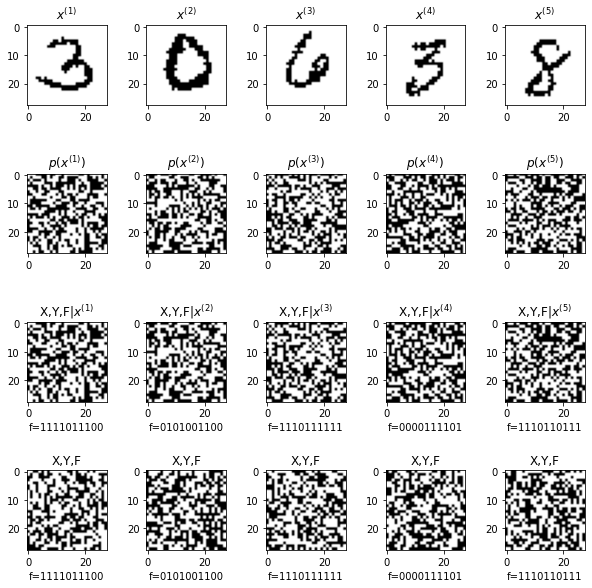

In [29]:
visualize(vae, get_batcher(valid_loader, args), args, N=5)

## Training

In [30]:
from collections import OrderedDict


def validate(vae, batcher, num_samples, compute_DR=False):
    """
    Return average NLL
        average number of bits per dimension
        and a dictionary with distortion and rate estimates
    """
    with torch.no_grad():
        vae.eval()
        
        nb_obs = 0
        nb_bits = 0.
        ll = 0.
        DR = OrderedDict()
        for x_obs, y_obs in batcher:
            # [B, H*W]
            x_obs = x_obs.reshape(-1, vae.p.data_dim)     
            # [B]
            ll = ll + vae.estimate_ll(x_obs, num_samples).sum(0)
            nb_bits += np.prod(x_obs.shape)
            nb_obs += x_obs.shape[0]
            # []
            if compute_DR:
                ret = vae.DR(x_obs)
                for k, v in ret.items():
                    if k not in DR:
                        DR[k] = []
                    DR[k].append(v.cpu().numpy())

    nll = - (ll / nb_obs).cpu()
    if compute_DR:
        DR = OrderedDict((k, np.concatenate(v, 0)) for k, v in DR.items())    
        return nll, nll / np.log(2) / vae.p.latent_dim, DR
    else:
        return nll, nll / np.log(2) / vae.p.latent_dim

In [31]:
from tqdm.auto import tqdm
from itertools import chain
from collections import defaultdict

### Optimiser

In [32]:
p_opt = torch.optim.Adam(p.parameters(), lr=args.gen_lr, weight_decay=args.gen_l2)
q_opt = torch.optim.Adam(q.parameters(), lr=args.inf_lr, weight_decay=args.inf_l2)
stats_tr = defaultdict(list)
stats_val = defaultdict(list)

### Steps

In [33]:
val_metrics = validate(vae, get_batcher(valid_loader, args), args.num_samples)
print(f'Validation {0:3d}: nll={val_metrics[0]:.2f} bpd={val_metrics[1]:.2f}')

Validation   0: nll=544.67 bpd=18.71


In [39]:
for epoch in range(args.epochs):

    iterator = tqdm(get_batcher(train_loader, args))

    for x_obs, y_obs in iterator:        
        # [B, H*W]
        x_obs = x_obs.reshape(-1, args.height * args.width)
        # [B, 10]
        context = None   
        
        vae.train()      
        loss, ret = vae.loss(x_obs)

        for k, v in ret.items():
            stats_tr[k].append(v)
                
        p_opt.zero_grad()
        q_opt.zero_grad()        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(
            chain(vae.gen_parameters(), vae.inf_parameters()), 
            args.grad_clip
        )        
        p_opt.step()
        q_opt.step()
    
        iterator.set_description(f'Epoch {epoch+1:3d}')
        iterator.set_postfix(ret)
    
    val_metrics = validate(vae, get_batcher(valid_loader, args), args.num_samples)
    stats_val['val_nll'].append(val_metrics[0])
    stats_val['val_bpd'].append(val_metrics[1])
    print(f'Validation {epoch+1:3d}: nll={val_metrics[0]:.2f} bpd={val_metrics[1]:.2f}')

  0%|          | 0/275 [00:00<?, ?it/s]

Validation   1: nll=177.49 bpd=6.10


  0%|          | 0/275 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Training Curves

In [40]:
np_stats_tr = {k: np.array(v) for k, v in stats_tr.items()}
np_stats_val = {k: np.array(v) for k, v in stats_val.items()}

In [41]:
def smooth(v, kernel_size=100):
    if kernel_size is None:
        return v
    return np.convolve(v, np.ones(kernel_size)/kernel_size, 'valid')

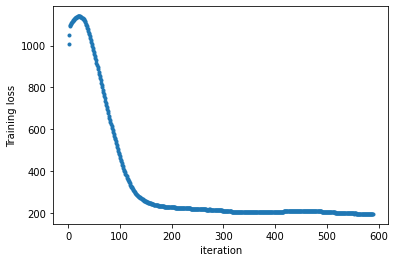

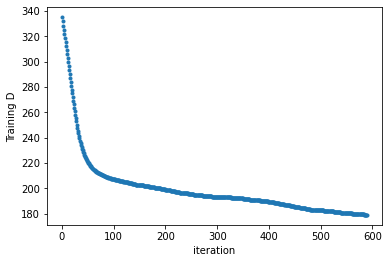

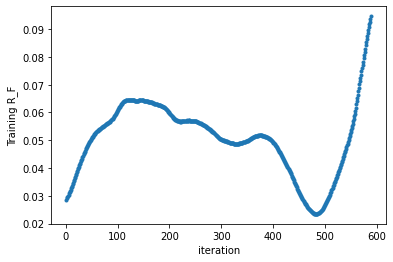

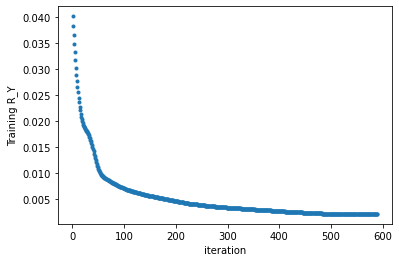

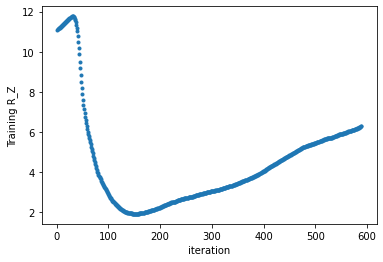

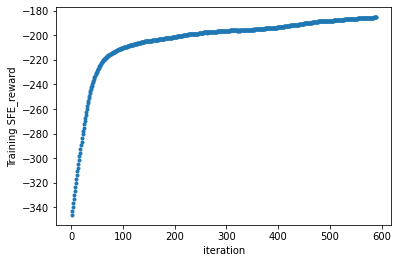

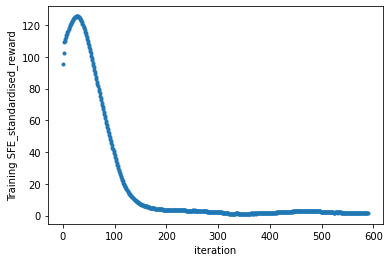

In [42]:
for k, v in np_stats_tr.items():
    v = smooth(v)
    plt.plot(np.arange(1, v.size + 1), v, '.')    
    plt.ylabel(f'Training {k}')
    plt.xlabel('iteration')
    plt.show()

### Validation Curves

In [43]:
from tabulate import tabulate

print(tabulate(
    [(k, np.mean(v[-100:]), np.min(v[-100:])) for k, v in np_stats_val.items()],
    headers=['metric', 'mean', 'min']
))

metric         mean        min
--------  ---------  ---------
val_nll   186.595    177.486
val_bpd     6.40953    6.09661


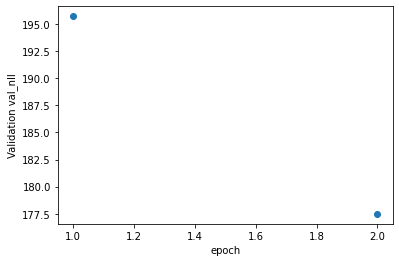

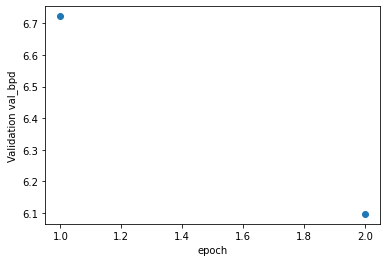

In [44]:
for k, v in np_stats_val.items():    
    plt.plot(np.arange(1, v.size + 1), v, 'o')
    plt.ylabel(f'Validation {k}')
    plt.xlabel('epoch')
    plt.show()

In [45]:
val_nll, val_bpd, val_DR = validate(
    vae, get_batcher(valid_loader, args), args.num_samples, compute_DR=True)

In [46]:
rows = [('IS-NLL', val_nll, None), ('IS-BPD', val_bpd, None)]
for k, v in val_DR.items():
    rows.append((k, v.mean(), v.std()))
print(tabulate(rows, headers=['metric', 'mean', 'std']))    

metric            mean          std
--------  ------------  -----------
IS-NLL    176.995
IS-BPD      6.07975
D         174.283       47.8586
R           6.91891      4.13668
R_F         0.133189     0.0750674
R_Y         0.00232516   0.00210162
R_Z         6.78339      4.10649


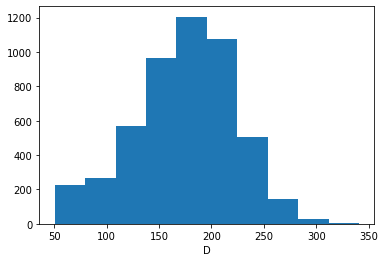

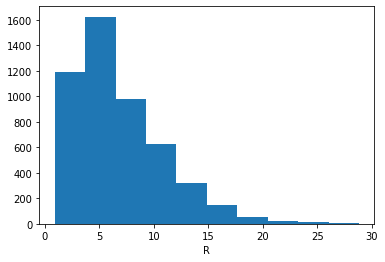

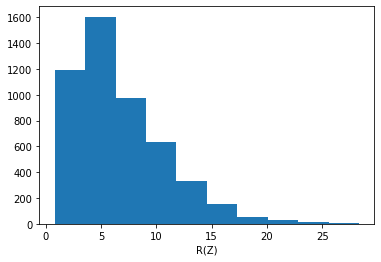

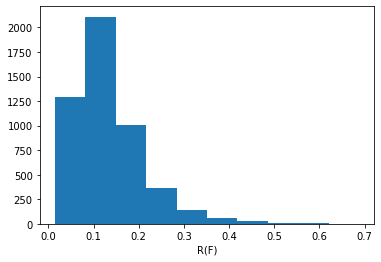

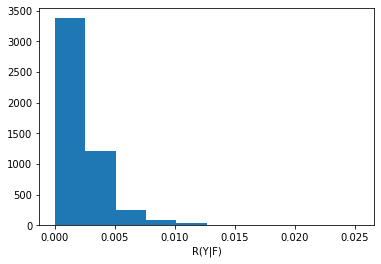

In [47]:
_ = plt.hist(val_DR['D'])
_ = plt.xlabel('D')
plt.show()

_ = plt.hist(val_DR['R'])
_ = plt.xlabel('R')
plt.show()

if vae.p.z_dim:
    _ = plt.hist(val_DR['R_Z'])
    _ = plt.xlabel('R(Z)')
    plt.show()
    
if vae.p.y_dim:
    _ = plt.hist(val_DR['R_F'])
    _ = plt.xlabel('R(F)')
    plt.show()

    _ = plt.hist(val_DR['R_Y'])
    _ = plt.xlabel('R(Y|F)')
    plt.show()

### Analysis

For a trained VAE: 
 1. We want to see that KL(Z|x || Z), KL(F|x || F), and KL(Y|f,x || Y|f) are generally > 0 for any x ~ D.


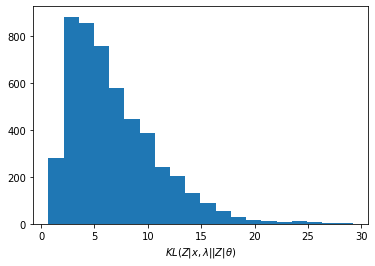

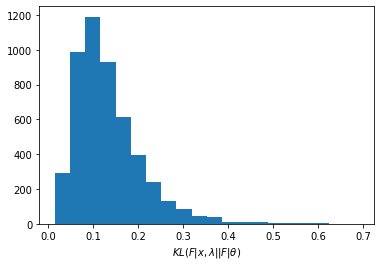

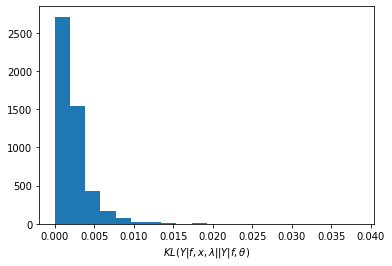

 2. But, marginally, we expect E_X[Z|X] ~ Z E_X[F|X] ~ F and E_FX[Y|F,X] ~ E_F[Y|F].


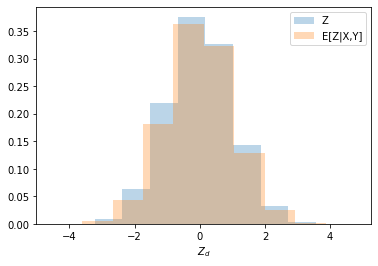

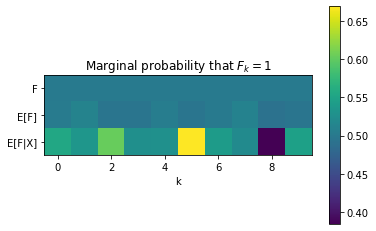

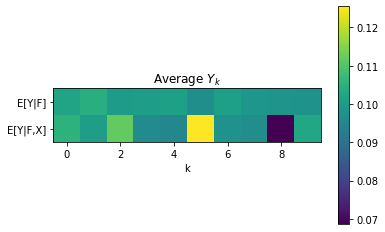

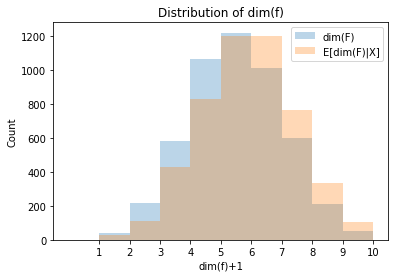

In [48]:
compare_p_q(vae, get_batcher(valid_loader, args), args)

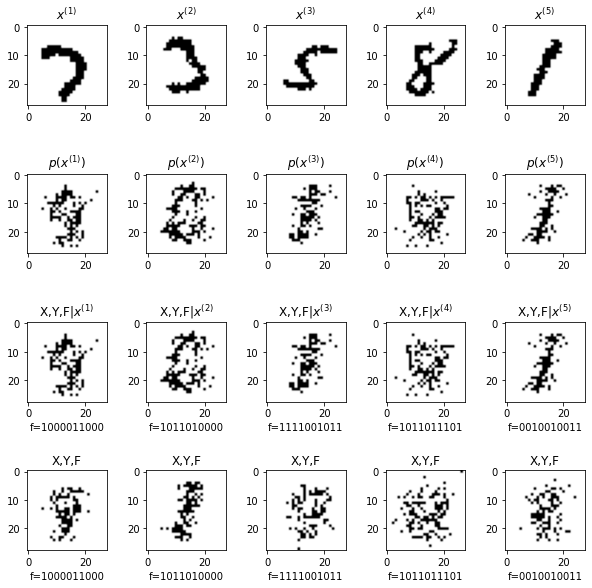

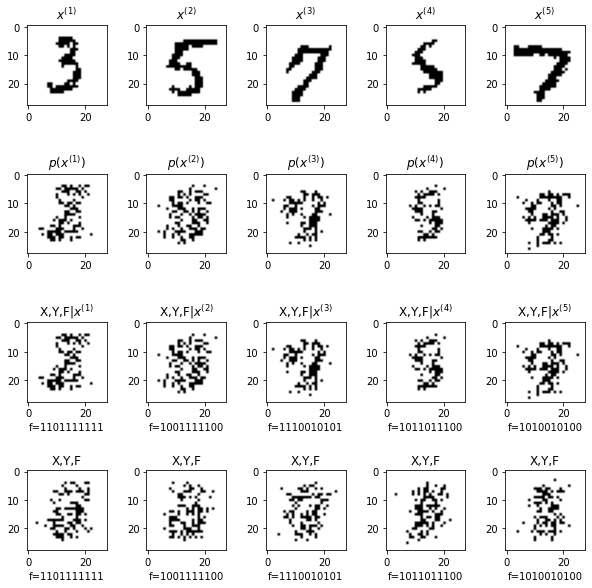

In [49]:
visualize(vae, get_batcher(valid_loader, args), args, N=5, num_figs=2)